<style>

div.input_prompt {
    display:none !important;
}

div.output_prompt {
    display:none !important;
}

div.output_area {
    padding-top: 4px;
    display: -webkit-box !important;
}

div.output_area pre {
    width: 100%;
}

div.output_text {
    background-color: #dcdcdc30 !important;
}

h1 {
	color: #C7AC5F;
	font-weight: bold;
}

h5, h4, h3, h2{
	color: #7A6F6D;
	font-weight: bold;
}

.rendered_html p {
    color: #5d7084 !important;
}

.rendered_html strong {
    color: black;
}


div.output_area .rendered_html table {
    width: 100%;
}

div#notebook-container .cell:nth-child(2) {
    display: none;
}

.prompt {
    display: none;
}

div#notebook-container {
    box-shadow: none;
}

@media (min-width: 1200px) {
  .container {
    width: 980px !important;
  }
}

img {
    display: block;
    margin-left: auto;
    margin-right: auto;
}

</style>

<script>
$(document).ready( function() {
    $(".output_png.output_subarea.output_execute_result").
        parents('.output_wrapper').
        prev().
        css("display", "none")
});
</script>

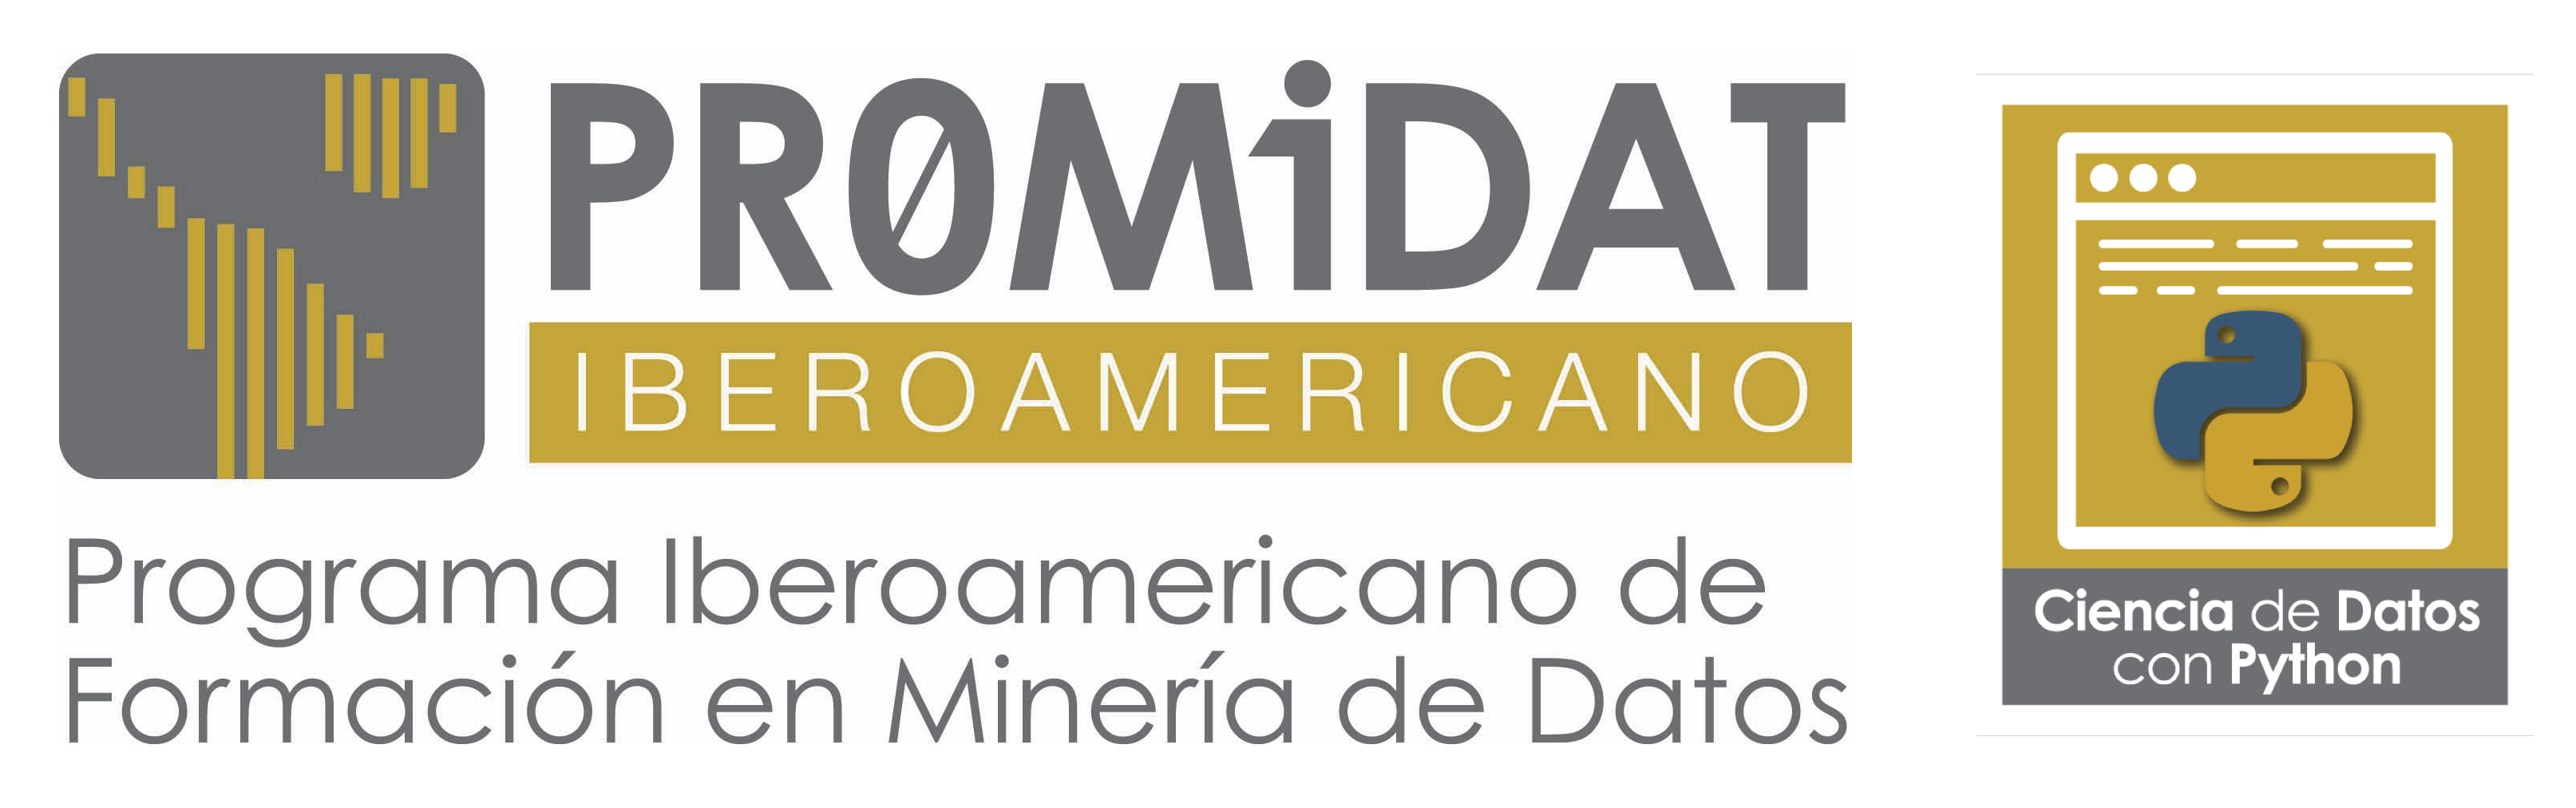

In [125]:
from IPython.display import Image
Image(filename='./logo_python.png')

In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

__Se cargan los datos__

In [2]:
datos = pd.read_csv('AAPL.csv',delimiter=",",decimal=".", index_col=0,parse_dates=['Date'])
datos.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.782110,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,24.083958,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,24.086227,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.423975,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.362394,237458000


In [4]:
# entrenaremos la Red LSTM usando únicamente el valor más alto 
# de la acción (columna High).

# para entrenamiento de la Red LSTM para training usaremos los datos de Enero de 2009 hasta Diciembre 2018
# para testing usaremos los datos del año 2019 

training = datos[:'2018'].iloc[:,1:2]
testing = datos['2019':].iloc[:,1:2]

training

,High
Date,
2015-01-02,27.860001
2015-01-05,27.162500
2015-01-06,26.857500
2015-01-07,27.049999
2015-01-08,28.037500
...,...
2018-12-24,37.887501
2018-12-26,39.307499
2018-12-27,39.192501


__Escalamos los datos__

In [8]:
scaler = StandardScaler()
sc_training = scaler.fit_transform(training)

__Ajustamos los sets de test y training__

In [11]:
#Para entrenar la Red LSTM tomaremos bloques de 60 datos consecutivos,
# y la idea es que cada uno de estos permita predecir el siguiente valor:
    
# Los bloques de 60 datos serán almacenados en la variable X,
# mientras que el dato que se debe predecir (el dato 61 dentro de 
# cada secuencia) se almacenará en la variable Y y será usado como 
# la salida de la Red LSTM:

time_step = 60

X_train = []
Y_train = []

m = len(sc_training)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(sc_training[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(sc_training[i,0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

__Creamos el set de testing (validación) y seguidamente lo escalamos__

In [12]:
x_test = testing.values
x_test = scaler.transform(x_test)

In [14]:
# El modelo fue entrenado para tomar 60 
# y generar un dato como predicción. Así que debemos
# reorganizar el set de validación (x_test) para que 
# tenga bloques de 60 datos:

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


Para crear la red debemos primero definir el tamaño de los datos de entrada y del dato de salida, así como el número total de neuronas (50):

In [15]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

__Creación del modelo__

In [16]:
#optmizador Gradiente Descendente y función de error error cuadrático medio

def create_simple_rnn():  

    modelo = Sequential()
    
    modelo.add(LSTM(units=na, input_shape=dim_entrada))
    modelo.add(Dense(units=dim_salida))
    modelo.compile(optimizer='rmsprop', loss='mse')

    return modelo

rnn_modelo = create_simple_rnn()  

__Resumen del modelo__

In [18]:

rnn_modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


__Entrenamiento del modelo__

In [19]:
# El entrenamiento se implementa de forma sencilla usando la función fit. 
# En este caso usaremos un total de 20 iteraciones (parámetro epochs)
# y presentaremos a la Red LSTM lotes de 32 datos (parámetro batch_size):

rnn_modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
79/79 [==============================] - 2s 2ms/step - loss: 0.4330
Epoch 2/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 3/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 4/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 5/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 6/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 7/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 8/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 9/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 10/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 11/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 12/20
79/79 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 13/20
79/79 [==============================

__Predicción del valor de la acción__

In [21]:
prediccion = rnn_modelo.predict(X_test)

# aplicamos la normalización inversa de dicha predicción
prediccion = scaler.inverse_transform(prediccion)


__Gráfico de la acción vsus predicción__

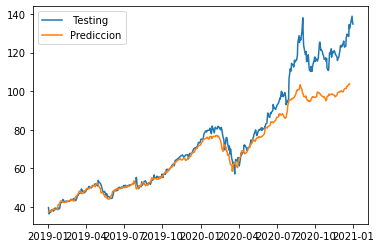

In [22]:
plt.plot(testing.index, testing.values, label = " Testing")
plt.plot(testing.index[0:len(X_test)], prediccion, label = "Prediccion")

plt.legend()